In [1]:
import warnings
warnings.filterwarnings("ignore")
import glob
from pathlib import Path

train_path = r"C:\Users\imreh\Desktop\Final Project\Notebook\training"
test_path  = r"C:\Users\imreh\Desktop\Final Project\Notebook\training_test1\test"

print('train images')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")
    
print('test images')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

train images
1738 	 blast
965 	 brown_spot
1594 	 hispa
1764 	 normal
test images
175 	 blast
97 	 brown_spot
160 	 hispa
177 	 normal


In [2]:
import numpy as np
import pandas as pd
import pickle
import cv2
import os

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import keras
keras.__version__
from psutil import virtual_memory

SEED = 123
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((224, 224))
image_size = 0
width = 224
height = 224
depth = 3

n_classes = len(glob.glob(train_path + '/*/'))
print(n_classes)

4


In [3]:
import os
from keras.models import Model
#from keras.optimizers import Adam
#from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.mobilenet import MobileNet, preprocess_input
#from keras.applications import MobileNet
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

def create_model_mobilenet(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = MobileNet(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
#     model.add(Dense(1024))
#     model.add(Activation("relu"))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2))
#     model.add(Dense(n_classes))
#     model.add(Activation("softmax"))
    
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

input_shape = (224, 224, 3)

# Use a smaller learning rate
optim_2 = Adam(learning_rate=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
model = create_model_mobilenet(input_shape, n_classes, optim_2, fine_tune=24)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [4]:
image_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 shear_range=0.2,
                 zoom_range=0.2,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1./255,
                                   validation_split=0.2)

train_generator = image_datagen.flow_from_directory(    
    directory = train_path,
    subset='training',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

valid_generator = image_datagen.flow_from_directory(    
    directory=train_path,
    subset='validation',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(    
    directory=test_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    classes=['.'],
    class_mode=None,
    shuffle=False,
    seed=SEED)

print(train_generator.class_indices)
print(test_generator.samples)

Found 4851 images belonging to 4 classes.
Found 1210 images belonging to 4 classes.
Found 609 images belonging to 1 classes.
{'blast': 0, 'brown_spot': 1, 'hispa': 2, 'normal': 3}
609


In [5]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='mobilenet_model6.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

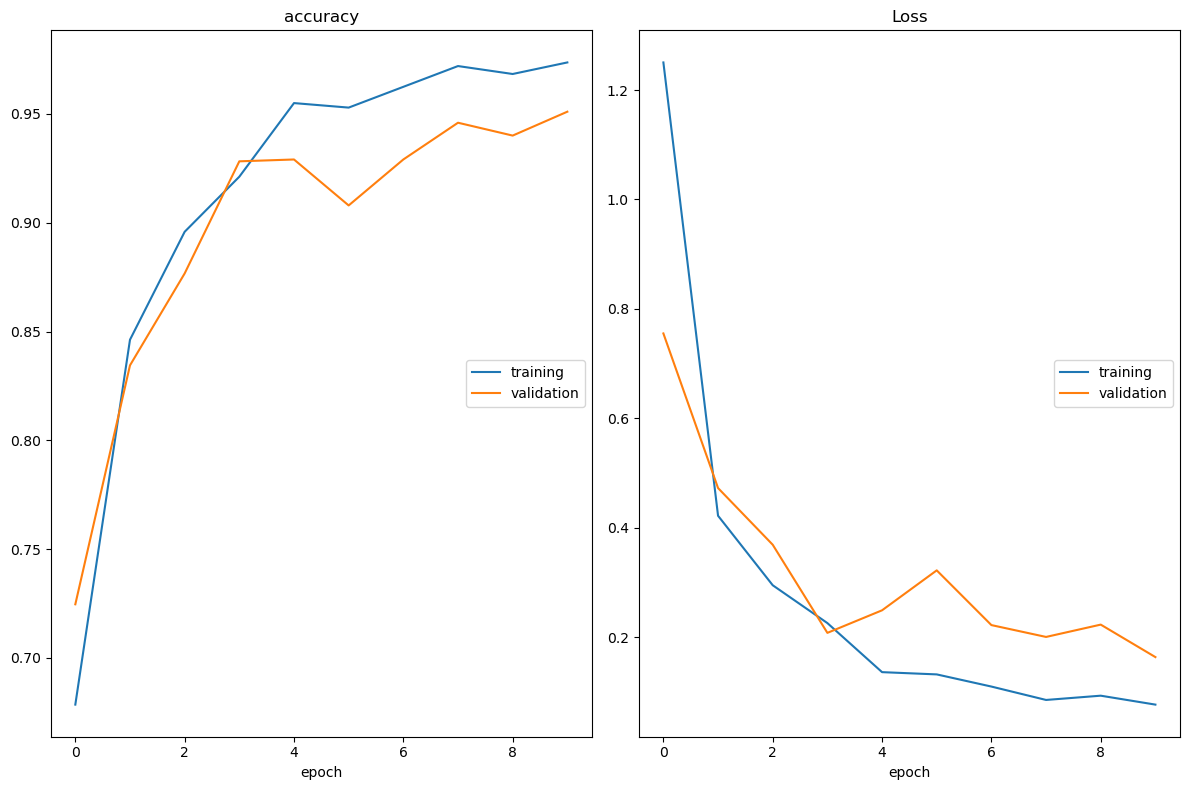

accuracy
	training         	 (min:    0.679, max:    0.974, cur:    0.974)
	validation       	 (min:    0.725, max:    0.951, cur:    0.951)
Loss
	training         	 (min:    0.076, max:    1.250, cur:    0.076)
	validation       	 (min:    0.163, max:    0.755, cur:    0.163)
151/151 [==============================] - 395s 3s/step - loss: 0.0764 - accuracy: 0.9736 - val_loss: 0.1633 - val_accuracy: 0.9510
Wall time: 1h 8min 49s


In [6]:
%%time

plot_loss_2 = PlotLossesCallback()

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

# Retrain model with fine-tuning
history = model.fit_generator(generator = train_generator,
                                  steps_per_epoch = STEP_SIZE_TRAIN,
                                  validation_data = valid_generator,
                                  validation_steps = STEP_SIZE_VALID,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1,epochs=EPOCHS)

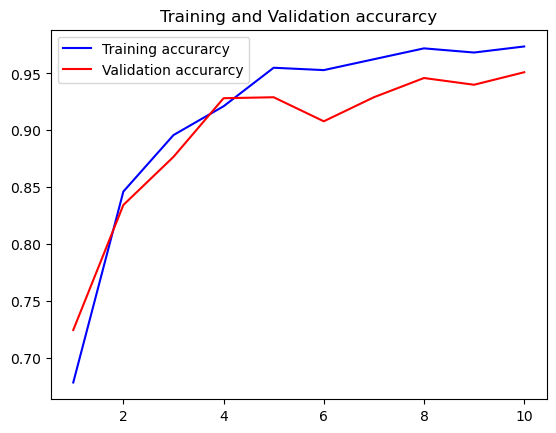

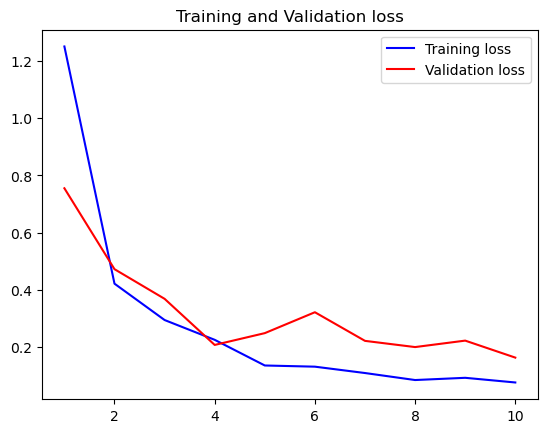

Wall time: 625 ms


In [7]:
%%time
temp = pd.DataFrame(history.history)
temp.to_csv('mobilenetv2_model6_history.csv', index=False)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [8]:
print('test images')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")
    
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(    
    directory=test_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    #classes=['.'],
    #class_mode="categorical",
    class_mode=None,
    shuffle=False,
    seed=SEED)

test images
175 	 blast
97 	 brown_spot
160 	 hispa
177 	 normal
Found 609 images belonging to 4 classes.


In [9]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

model.load_weights('mobilenet_model6.weights.best.hdf5')
pred = model.predict_generator(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)
pred_classes = np.argmax(pred, axis=1)

C:\Users\imreh\AppData\Local\Temp\ipykernel_11100\3048495735.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_generator,


609/609 [==============================] - 53s 85ms/step


In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

class_names = test_generator.class_indices.keys()
true_classes = test_generator.classes

acc = accuracy_score(true_classes, pred_classes)
print("mobilenet Model Accuracy : {:.2f}%".format(acc * 100))

cls_report = classification_report(true_classes, pred_classes, 
                                   target_names=class_names, digits=5)
print(cls_report)

mobilenet Model Accuracy : 98.85%
              precision    recall  f1-score   support

       blast    0.98857   0.98857   0.98857       175
  brown_spot    0.97980   1.00000   0.98980        97
       hispa    0.99359   0.96875   0.98101       160
      normal    0.98883   1.00000   0.99438       177

    accuracy                        0.98851       609
   macro avg    0.98770   0.98933   0.98844       609
weighted avg    0.98857   0.98851   0.98847       609



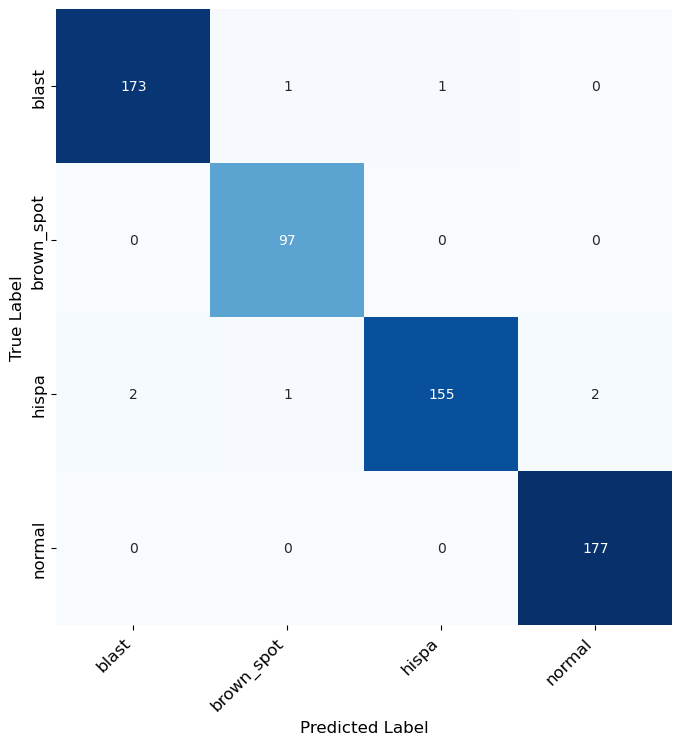

[[173   1   1   0]
 [  0  97   0   0]
 [  2   1 155   2]
 [  0   0   0 177]]


In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

plot_heatmap(true_classes, pred_classes, class_names, ax, title="CNN")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(true_classes, pred_classes)
print(cm)

In [12]:
loss, acc = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
print(acc, loss)

C:\Users\imreh\AppData\Local\Temp\ipykernel_11100\3805160915.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)


609/609 [==============================] - 11s 17ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
0.0 0.0


In [13]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

normal        179
blast         175
hispa         156
brown_spot     99
dtype: int64

In [28]:
filenames=test_generator.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission-model6.csv",index=False)
results.head()

C:\Users\imreh\AppData\Local\Temp\ipykernel_11100\2890077379.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  results.image_id = results.image_id.str.replace('./', '')


,image_id,label
0,blast\100161.jpg,blast
1,blast\100217.jpg,blast
2,blast\100219.jpg,blast
3,blast\100282.jpg,blast
4,blast\100500.jpg,blast


In [16]:
model.save(r"C:\Users\imreh\Desktop\Final Project\Notebook\mobilenetv2_model-6.h5")

In [21]:
from IPython.display import FileLink
# Link the files
FileLink(r"C:\Users\imreh\Desktop\Final Project\Notebook\mobilenetv2_model-6.h5")

C:\Users\imreh\Desktop\Final Project\Notebook\mobilenetv2_model-6.h5

In [25]:
import json
# Dump the categories
with open("categories(model-6).json", "w") as file:
  json.dump(train_generator.class_indices, file)

In [26]:
# Link categories JSON
FileLink("categories(model-6).json")

C:\Users\imreh\Desktop\Final Project\Notebook\categories(model-6).json